In [1]:
import numpy as np
import pandas as pd
import os
import sys

In [2]:
# Setting path to load util functions
from pathlib import Path
parent_dir = Path.cwd().parents[1]
sys.path.append(os.path.abspath(parent_dir))

In [3]:
from utils.inference_helpers import load_data
df = load_data(data_path='../../data/0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a.parquet')

In [4]:
from utils.inference_helpers import filter_and_impute_df
df = filter_and_impute_df(df, non_null_cols_path='../../utils/selected_features/non_null_cols_filter.csv')

c:\Users\vaseekaranv\Desktop\NIBM-MSc\FYP\utils\inference_helpers.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[cat_cols] = df[cat_cols].astype('category')


In [5]:
from utils.inference_helpers import encode_df
df = encode_df(df, cat_encoder_path='../../utils/encoders/categorical_encoder.pkl')

In [6]:
df.shape

(13, 91)

In [7]:
from utils.inference_helpers import create_ts_features
ts_df = create_ts_features(df, imp_cols_path='../../utils/selected_features/boruta_features_baseline.csv',
                           ts_feat_imp_path='../../utils/selected_features/ts_features_boruta.csv')

Aggregated DataFrame type: <class 'pandas.core.frame.DataFrame'>


Creating time series features for each feature:   0%|          | 0/47 [00:00<?, ?it/s]

Creating time series features for each feature: 100%|██████████| 47/47 [00:00<00:00, 91.72it/s] 

Concatenating 282 feature DataFrames.


In [8]:
from utils.inference_helpers import create_tsfel_features
tsfel_df = create_tsfel_features(df,
                                 imp_cols_path='../../utils/selected_features/boruta_features_baseline.csv',
                                 stat_select_path='../../utils/selected_features/tsfel_stat_features_boruta.csv',
                                 temporal_select_path='../../utils/selected_features/tsfel_temporal_features_boruta.csv')

Input shape: (13, 49), Grouping by: customer_ID, Timestamp: end_of_month
Using provided TSFEL configuration dictionary.
Processing 1 customer groups...
Setting up Joblib with 20 processes (verbose=0)...

Joblib parallel processing finished in 2.75 seconds.
Successfully processed 1 out of 1 groups.
Preparing results for concatenation...
Concatenating reindexed results...
Concatenation complete.
Robust concatenation finished in 0.22 seconds.
Final features DataFrame shape: (1, 2115)


In [9]:
from utils.inference_helpers import combine_dfs
final_df = combine_dfs(df=df, ts_df=ts_df, tsfel_df=tsfel_df, ref_cols_path='../../data/final_features_ml/val_all_features_last_month.parquet')
final_df.shape

(1, 426)

In [11]:
#load model
import pickle
with open('../../models/machine_learning/eec_xgb_tuned.pkl', 'rb') as f:
    model = pickle.load(f)

In [12]:
model.predict(final_df.drop(columns=['customer_ID']))

array([0], dtype=int64)

In [13]:
model.predict_proba(final_df.drop(columns=['customer_ID']))

array([[0.99810282, 0.00189718]])

In [14]:
train_df = pd.read_parquet('../../data/final_features_ml/train_all_features_last_month.parquet')
train_df.head()

,customer_ID,D_39,B_1,R_1,B_4,B_5,R_2,D_47,B_7,D_51,...,S_5_Signal distance,B_14_Mean diff,B_11_Mean diff,S_8_Area under the curve,B_11_Area under the curve,S_8_Centroid,B_1_Area under the curve,B_1_Mean diff,S_26_Area under the curve,S_5_Area under the curve
0,a6bce6027f34a537dd3791ede37dcd3bf7017d571e3b8a...,0.295018,0.094310,0.005200,0.170079,0.017262,0.003640,0.422436,0.127707,0.341604,...,12.029161,0.007358,0.006325,0.029952,0.011324,0.085800,0.013038,0.007075,0.006801,0.027373
1,22b6b23f06a467df6633cbcf3e3fb7e8a99c692e19d500...,0.007106,0.013758,0.000326,0.058616,0.018488,0.008559,0.322846,0.028203,0.343203,...,12.068850,-0.001390,-0.000399,0.090383,0.003680,0.051497,0.005548,-0.000849,0.000461,0.012319
2,baac3615b0e82e210320261b87b2e8e552805f5b66f0d2...,0.005607,0.008563,0.004398,0.000113,0.015878,0.002745,0.104074,0.013242,0.006555,...,11.002209,-0.000009,0.000587,0.069793,0.001199,0.057995,0.002053,-0.000671,0.000324,0.002690
3,ca8cba88feeed4b3759eba6f32c12192025691826cdeff...,0.005659,0.000993,0.000691,0.008777,0.005575,0.003091,0.161946,0.001729,0.002436,...,12.000042,-0.000155,-0.000549,0.008603,0.003057,0.083004,0.003974,-0.000154,0.000598,0.000624
4,834dfa4bb957dabcbc2d9e90f8998b9cf40bcc35f38536...,0.000834,0.005034,0.005587,0.046676,0.000355,0.008184,0.698026,0.031777,0.003444,...,12.000103,0.000277,-0.000100,0.000655,0.000589,0.066338,0.000707,0.000017,0.000729,0.000705


In [15]:
import shap
explainer = shap.Explainer(model.predict_proba, train_df.drop(columns=['customer_ID']), model_output = 'probability')

In [16]:
shap_values = explainer(final_df.drop(columns=['customer_ID']), max_evals = 844)

In [17]:
shap_values[..., 1][0].shape

(425,)

In [18]:
shap_values_1 = shap_values[..., 1]


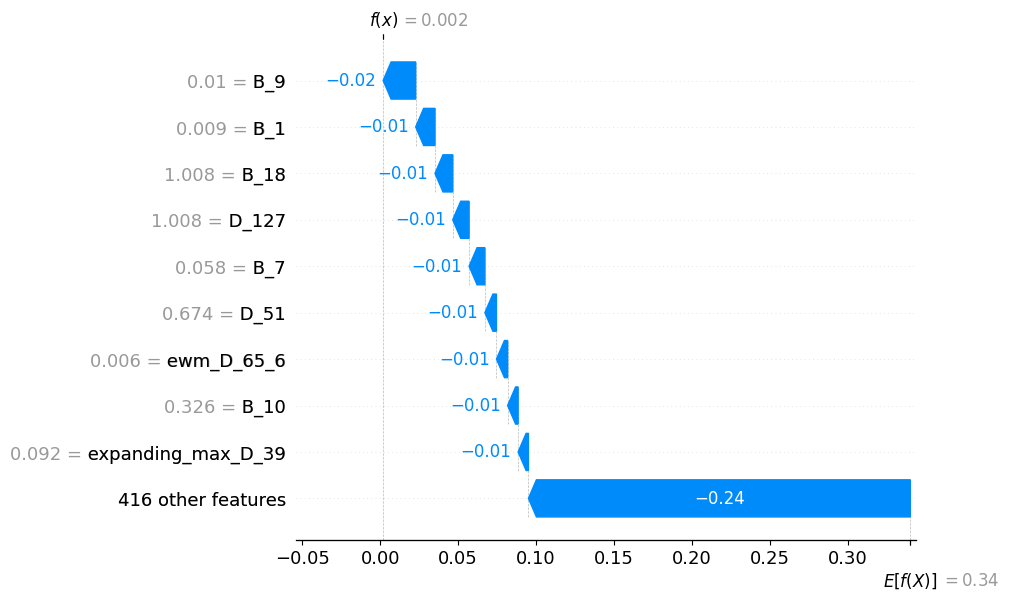

In [19]:
shap.plots.waterfall(shap_values_1[0])


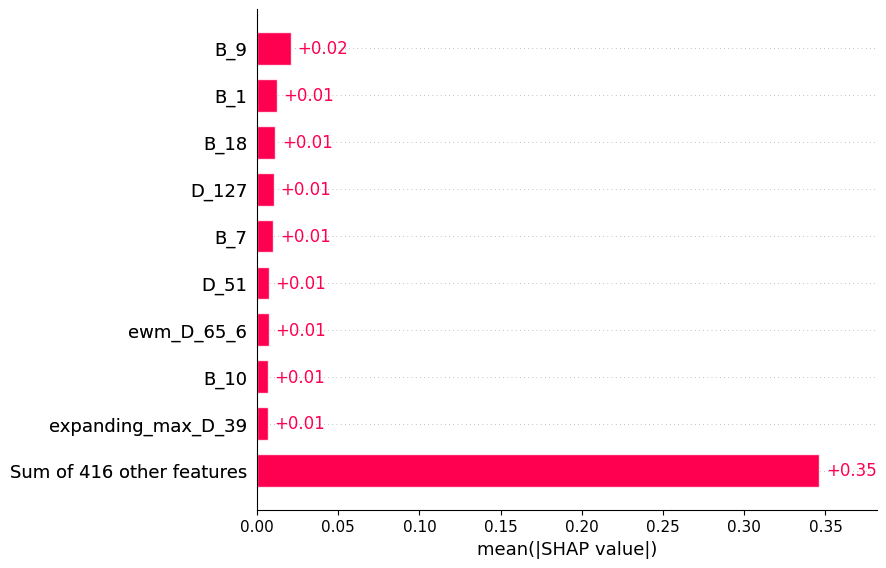

In [20]:
shap.plots.bar(shap_values_1)


In [21]:
import os
import sys
import pickle
import shap
import pandas as pd
from pathlib import Path
from utils.inference_helpers import (
    load_data,
    filter_and_impute_df,
    encode_df,
    create_ts_features,
    create_tsfel_features,
    combine_dfs
)

def run_pipeline(data_path, non_null_cols_path, cat_encoder_path, ts_feat_imp_path, 
                 imp_cols_path, stat_select_path, temporal_select_path, ref_cols_path, 
                 model_path, train_data_path):
    """
    Executes the pipeline to load data, preprocess it, generate predictions, probabilities, 
    and SHAP waterfall plots.

    Parameters:
        data_path (str): Path to the input data file.
        non_null_cols_path (str): Path to the non-null columns filter CSV.
        cat_encoder_path (str): Path to the categorical encoder pickle file.
        ts_feat_imp_path (str): Path to the time-series feature importance CSV.
        imp_cols_path (str): Path to the important columns CSV.
        stat_select_path (str): Path to the TSFEL statistical features CSV.
        temporal_select_path (str): Path to the TSFEL temporal features CSV.
        ref_cols_path (str): Path to the reference columns parquet file.
        model_path (str): Path to the trained model pickle file.
        train_data_path (str): Path to the training data parquet file.

    Returns:
        None
    """
    # Load data
    df = load_data(data_path=data_path)

    # Filter and impute data
    df = filter_and_impute_df(df, non_null_cols_path=non_null_cols_path)

    # Encode categorical features
    df = encode_df(df, cat_encoder_path=cat_encoder_path)

    # Create time-series features
    ts_df = create_ts_features(df, imp_cols_path=imp_cols_path, ts_feat_imp_path=ts_feat_imp_path)

    # Create TSFEL features
    tsfel_df = create_tsfel_features(
        df,
        imp_cols_path=imp_cols_path,
        stat_select_path=stat_select_path,
        temporal_select_path=temporal_select_path
    )

    # Combine all dataframes
    final_df = combine_dfs(df=df, ts_df=ts_df, tsfel_df=tsfel_df, ref_cols_path=ref_cols_path)

    # Load the model
    with open(model_path, 'rb') as f:
        model = pickle.load(f)

    # Generate predictions and probabilities
    predictions = model.predict(final_df.drop(columns=['customer_ID']))
    probabilities = model.predict_proba(final_df.drop(columns=['customer_ID']))

    # Load training data for SHAP
    train_df = pd.read_parquet(train_data_path)

    # Initialize SHAP explainer
    explainer = shap.Explainer(model.predict_proba, train_df.drop(columns=['customer_ID']), model_output='probability')

    # Compute SHAP values
    shap_values = explainer(final_df.drop(columns=['customer_ID']), max_evals=844)

    # Generate SHAP waterfall plot for the first prediction
    shap.plots.waterfall(shap_values[..., 1][0])

    # Generate SHAP bar plot
    shap.plots.bar(shap_values[..., 1])

    return predictions, probabilities

c:\Users\vaseekaranv\Desktop\NIBM-MSc\FYP\utils\inference_helpers.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[cat_cols] = df[cat_cols].astype('category')


Aggregated DataFrame type: <class 'pandas.core.frame.DataFrame'>


Creating time series features for each feature: 100%|██████████| 47/47 [00:00<00:00, 113.80it/s]


Concatenating 282 feature DataFrames.
Input shape: (13, 49), Grouping by: customer_ID, Timestamp: end_of_month
Using provided TSFEL configuration dictionary.
Processing 1 customer groups...
Setting up Joblib with 20 processes (verbose=0)...

Joblib parallel processing finished in 1.65 seconds.
Successfully processed 1 out of 1 groups.
Preparing results for concatenation...
Concatenating reindexed results...
Concatenation complete.
Robust concatenation finished in 0.34 seconds.
Final features DataFrame shape: (1, 2115)


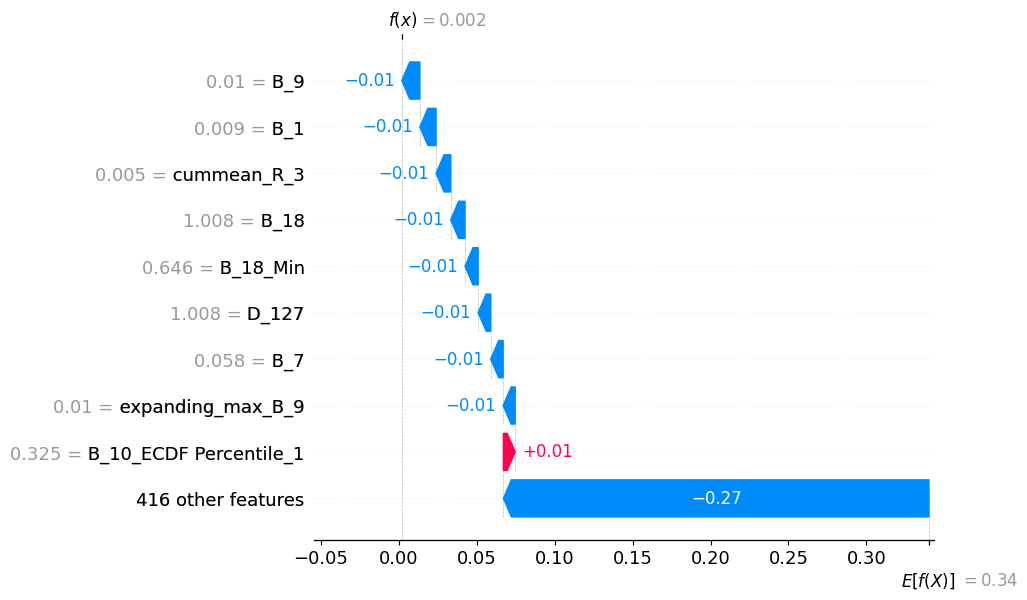

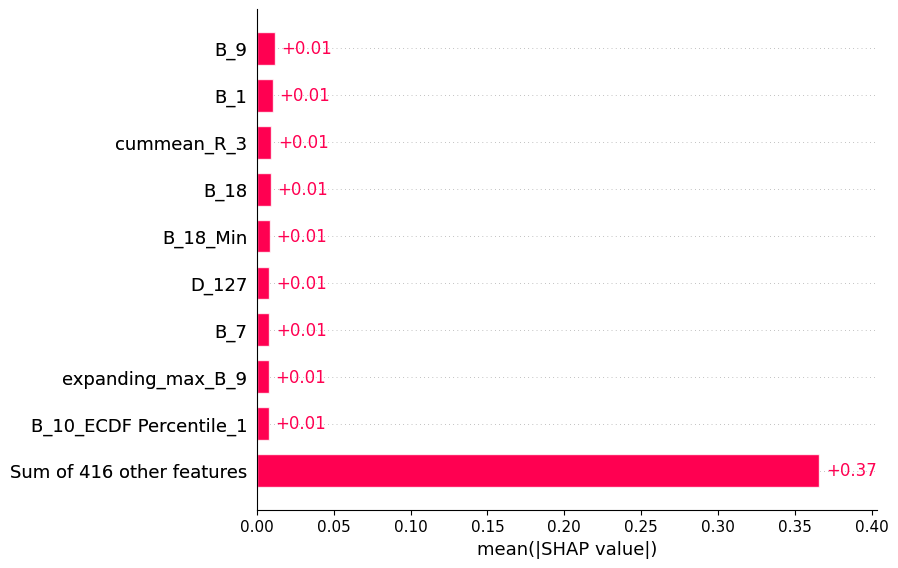

In [22]:
predictions, probabilities = run_pipeline(
    data_path='../../data/0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a.parquet',
    non_null_cols_path='../../utils/selected_features/non_null_cols_filter.csv',
    cat_encoder_path='../../utils/encoders/categorical_encoder.pkl',
    ts_feat_imp_path='../../utils/selected_features/ts_features_boruta.csv',
    imp_cols_path='../../utils/selected_features/boruta_features_baseline.csv',
    stat_select_path='../../utils/selected_features/tsfel_stat_features_boruta.csv',
    temporal_select_path='../../utils/selected_features/tsfel_temporal_features_boruta.csv',
    ref_cols_path='../../data/final_features_ml/val_all_features_last_month.parquet',
    model_path='../../models/machine_learning/eec_xgb_tuned.pkl',
    train_data_path='../../data/final_features_ml/train_all_features_last_month.parquet'
)

In [23]:
predictions, probabilities

(array([0], dtype=int64), array([[0.99810282, 0.00189718]]))